In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm
from numpy import unique, where
from collections import Counter
from sklearn.cluster import DBSCAN, KMeans
from sklearn.metrics import silhouette_score
from matplotlib import pyplot as plt
from sklearn.metrics.pairwise import euclidean_distances
import torch

import sys
sys.path.append("..")
from util.vis import t_sne, pca
from util.style_model import StyleModel
from util.clustering_eval import clustering_summary, print_clustering_classes, clustering_spacy_evaluation

/opt/homebrew/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
test_data = pd.read_pickle('../data/04c_Test_Set.pkl')

# Style Embeddings from Style Model

In [3]:
model = StyleModel()
model.load_state_dict(torch.load('../model/StyleModel.pt'))

<All keys matched successfully>

In [4]:
messages = test_data["message"].tolist()

vectors = []

for message in tqdm(messages):
    vectors.append(model(message).squeeze().detach().numpy())

vectors = np.array(vectors)

100%|██████████| 10684/10684 [03:09<00:00, 56.32it/s]


## Centroids

In [5]:
authors_centroids = {}

for group in test_data.groupby('author_email'):
    author_embeddings = np.array(vectors[group[1].index])
    authors_centroids[group[0]] = np.mean(author_embeddings, axis = 0)

In [32]:
centroids_array = [value for value in authors_centroids.values()]

distances = pd.DataFrame(euclidean_distances(centroids_array, centroids_array))

for i in range(len(distances)):
    for j in range(i + 1):
        distances[j][i] = 0

distances.index = ['Author 1', 'Author 2', 'Author 3', 'Author 4', 'Author 5', 'Author 6', 'Author 7']
distances.columns = ['Author 1', 'Author 2', 'Author 3', 'Author 4', 'Author 5', 'Author 6', 'Author 7']

distances.style.background_gradient(cmap='coolwarm').set_precision(3)

,Author 1,Author 2,Author 3,Author 4,Author 5,Author 6,Author 7
Author 1,0.000,0.301,0.300,0.291,0.187,0.406,0.399
Author 2,0.000,0.000,0.332,0.376,0.275,0.435,0.379
Author 3,0.000,0.000,0.000,0.351,0.232,0.358,0.422
Author 4,0.000,0.000,0.000,0.000,0.355,0.429,0.437
Author 5,0.000,0.000,0.000,0.000,0.000,0.395,0.400
Author 6,0.000,0.000,0.000,0.000,0.000,0.000,0.180
Author 7,0.000,0.000,0.000,0.000,0.000,0.000,0.000


## PCA & t-SNE Visualizations

First, the generated vectors are reduced to two and three dimensions with PCA and t-SNE and visualized. Each of the seven authors gets a different color.

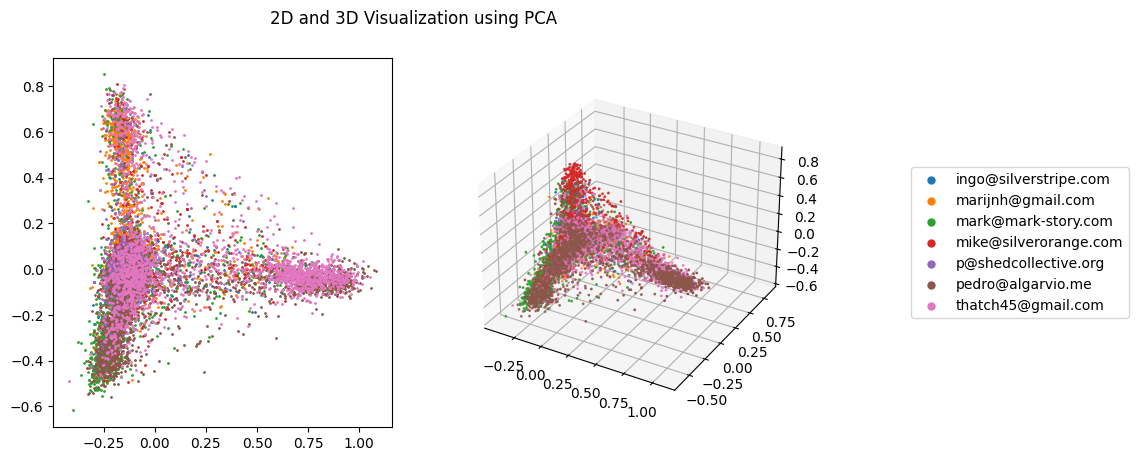

In [7]:
pca_2_prediction, pca_3_prediction = pca(vectors, test_data)

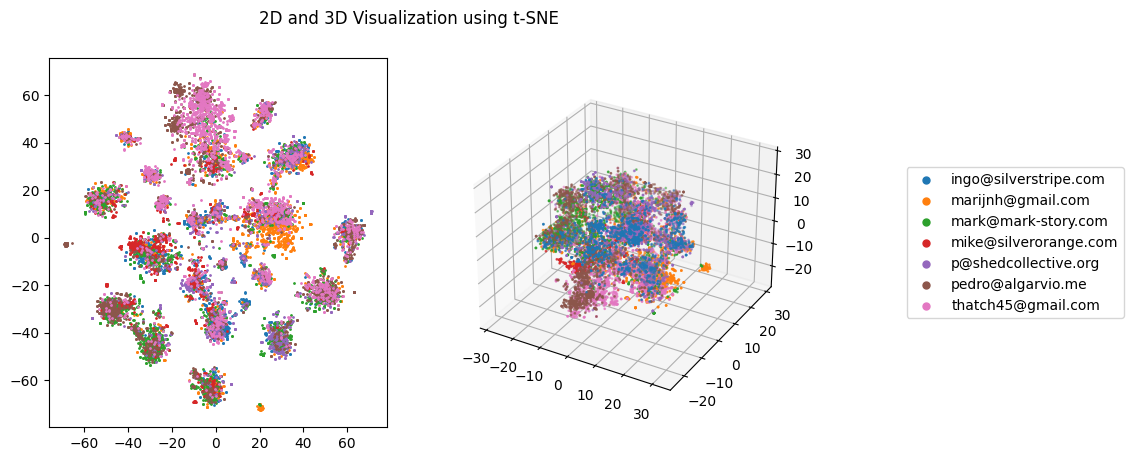

In [8]:
t_sne_2_prediction, t_sne_3_prediction = t_sne(vectors, test_data)

## DBSCAN

DBSCAN: Density-based, no number of clusters needed, ability to provide min_samples to make one cluster

Number of Clusters: 6
10 Most common:
[(0, 9320), (-1, 1272), (1, 49), (2, 21), (3, 12), (4, 10)]


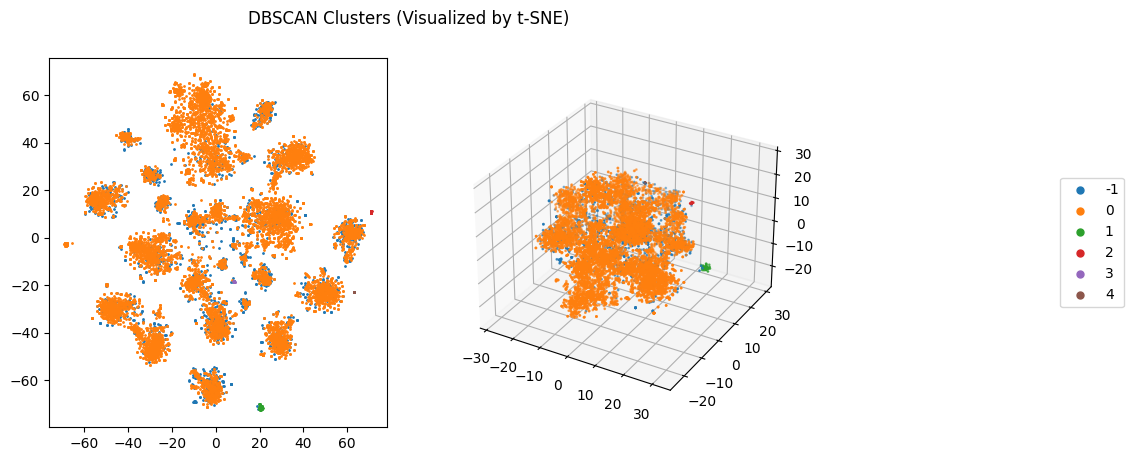

In [9]:
dbscan_model = DBSCAN(eps=0.7, min_samples=10)
dbscan_prediction = dbscan_model.fit_predict(vectors)

dbscan_clusters = unique(dbscan_prediction)

print(f"Number of Clusters: {len(dbscan_clusters)}")
print("10 Most common:")
print(Counter(dbscan_prediction).most_common(10))

fig = plt.figure(figsize=plt.figaspect(0.5))
ax2 = fig.add_subplot(1, 2, 1)
ax3 = fig.add_subplot(1, 2, 2, projection='3d')

for dbscan_cluster in dbscan_clusters:
    index = where(dbscan_prediction == dbscan_cluster)[0]
    ax2.scatter(t_sne_2_prediction[index, 0], t_sne_2_prediction[index, 1], s=1, label=dbscan_cluster)
    ax3.scatter(t_sne_3_prediction[index, 0], t_sne_3_prediction[index, 1], t_sne_3_prediction[index, 2], s=1, label=dbscan_cluster)

fig.suptitle("DBSCAN Clusters (Visualized by t-SNE)")
plt.legend(loc=5, bbox_to_anchor=(2, 0.5), markerscale = 5)
plt.show()

In [10]:
dbscan_summary = clustering_summary(dbscan_prediction, test_data)
dbscan_summary

There are 7 different authors.
There are 91 different projects.


,Number of Messages,Number of different Authors,Median number of commits per different Author,Most common Author,Number of different Projects,Median number of commits per different Project,Most common project
0,1272.0,7.0,186.0,"('thatch45@gmail.com', 261)",61.0,3.0,"('saltstack_salt', 411)"
1,9320.0,7.0,1256.0,"('mark@mark-story.com', 1870)",86.0,7.0,"('saltstack_salt', 3377)"
2,49.0,2.0,24.5,"('marijnh@gmail.com', 47)",3.0,2.0,"('codemirror_CodeMirror', 46)"
3,21.0,1.0,21.0,"('p@shedcollective.org', 21)",13.0,2.0,"('nails_common', 3)"
4,12.0,5.0,1.0,"('p@shedcollective.org', 7)",8.0,1.0,"('nails_common', 4)"
5,10.0,1.0,10.0,"('pedro@algarvio.me', 10)",1.0,10.0,"('saltstack_salt', 10)"


In [11]:
dbscan_summary.describe()

,Number of Messages,Number of different Authors,Median number of commits per different Author,Number of different Projects,Median number of commits per different Project
count,6.000000,6.000000,6.000000,6.000000,6.000000
mean,1780.666667,3.833333,249.750000,28.666667,4.166667
std,3727.165876,2.857738,497.799935,35.858983,3.544949
min,10.000000,1.000000,1.000000,1.000000,1.000000
25%,14.250000,1.250000,12.750000,4.250000,2.000000
50%,35.000000,3.500000,22.750000,10.500000,2.500000
75%,966.250000,6.500000,145.625000,49.000000,6.000000
max,9320.000000,7.000000,1256.000000,86.000000,10.000000


In [12]:
clustering_spacy_evaluation(dbscan_prediction, test_data)

,0,1,2,3,4,5
length_mean,85.828616,75.155579,72.673469,59.571429,65.916667,28.000000
length_std,66.593202,56.500152,28.489445,14.584961,24.356581,0.000000
n_uppercase_mean,4.261792,3.546674,2.326531,13.380952,2.750000,2.000000
n_uppercase_std,4.858195,4.274710,1.434100,6.252437,2.005202,0.000000
polarity_mean,0.029392,0.010272,0.036348,0.000000,-0.077546,0.000000
polarity_std,0.195549,0.177245,0.144398,0.000000,0.278786,0.000000
subjectivity_mean,0.229853,0.186798,0.152688,0.083333,0.399769,0.000000
subjectivity_std,0.294425,0.279980,0.245419,0.149956,0.395217,0.000000


In [13]:
print_clustering_classes(dbscan_prediction, test_data)


________________ Class 0 ________________

___
1) 
Set omnipay response earlier in PurchaseService

It might be used in onCaptured callbacks
___
2) 
Added iShouldSeeAButton assertion
___
3) 
Fixed Behat scope for "I log in as"

Fixes an issues where multiple "Email" form fields are present
on a page, e.g. through a global login overlay in the header.
___
4) 
mlanthaler: Refactored the created code since the coding conventions for static methods were changed (ticket #<I>). 
(merged from branches/gsoc)


git-svn-id: svn://svn.silverstripe.com/silverstripe/open/modules/sapphire/trunk@<I> <I>b<I>ca-7a2a-<I>-9d3b-<I>d<I>a<I>a9
___
5) 
mlanthaler: Refactored the created code since the coding conventions for static methods were changed (ticket #<I>). 
(merged from branches/gsoc)


git-svn-id: svn://svn.silverstripe.com/silverstripe/open/modules/sapphire/trunk@<I> <I>b<I>ca-7a2a-<I>-9d3b-<I>d<I>a<I>a9
___
6) 
BUG Exclude meta info from SolrCell content retrieval

Was matching </str> greedily,

## K-Means

Centroid-Based, fixed number of Clusters

Goal: Find seven clusters for seven authors

Number of Clusters: 21
10 Most common:
[(0, 1293), (2, 1124), (4, 731), (1, 730), (15, 616), (8, 593), (20, 579), (17, 551), (13, 530), (7, 523)]


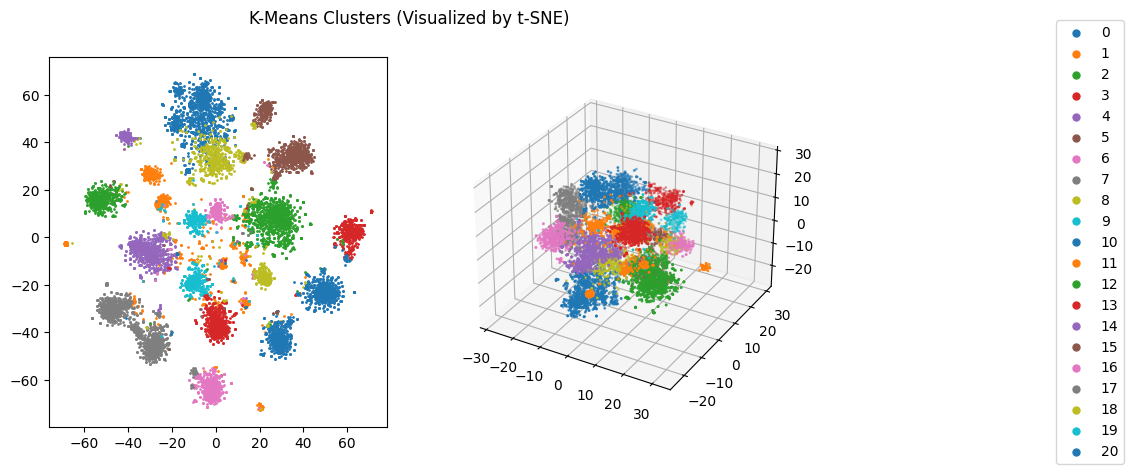

In [26]:
kmeans = KMeans(21)
kmeans_prediction = kmeans.fit_predict(vectors)

kmeans_clusters = unique(kmeans_prediction)

print(f"Number of Clusters: {len(kmeans_clusters)}")
print("10 Most common:")
print(Counter(kmeans_prediction).most_common(10))

fig = plt.figure(figsize=plt.figaspect(0.5))
ax2 = fig.add_subplot(1, 2, 1)
ax3 = fig.add_subplot(1, 2, 2, projection='3d')

for cluster in kmeans_clusters:
    index = where(kmeans_prediction == cluster)[0]
    ax2.scatter(t_sne_2_prediction[index, 0], t_sne_2_prediction[index, 1], s=1, label=cluster)
    ax3.scatter(t_sne_3_prediction[index, 0], t_sne_3_prediction[index, 1], t_sne_3_prediction[index, 2], s=1, label=cluster)

fig.suptitle("K-Means Clusters (Visualized by t-SNE)")
plt.legend(loc=5, bbox_to_anchor=(2, 0.5), markerscale = 5)
plt.show()

In [27]:
silhouette_score(vectors, kmeans_prediction)

0.22891213

In [28]:
kmeans_summary = clustering_summary(kmeans_prediction, test_data)
kmeans_summary

There are 7 different authors.
There are 91 different projects.


,Number of Messages,Number of different Authors,Median number of commits per different Author,Most common Author,Number of different Projects,Median number of commits per different Project,Most common project
0,1293.0,7.0,27.0,"('thatch45@gmail.com', 628)",22.0,1.5,"('saltstack_salt', 1190)"
1,730.0,7.0,93.0,"('ingo@silverstripe.com', 148)",43.0,2.0,"('saltstack_salt', 225)"
2,1124.0,7.0,103.0,"('marijnh@gmail.com', 515)",36.0,3.5,"('codemirror_CodeMirror', 398)"
3,442.0,7.0,54.0,"('pedro@algarvio.me', 155)",36.0,2.0,"('saltstack_salt', 217)"
4,731.0,7.0,49.0,"('mike@silverorange.com', 288)",45.0,2.0,"('silverorange_swat', 283)"
5,236.0,7.0,32.0,"('thatch45@gmail.com', 75)",29.0,2.0,"('saltstack_salt', 120)"
6,443.0,7.0,62.0,"('mark@mark-story.com', 141)",37.0,2.0,"('cakephp_cakephp', 129)"
7,523.0,7.0,30.0,"('mark@mark-story.com', 311)",35.0,2.0,"('cakephp_cakephp', 287)"
8,593.0,7.0,75.0,"('thatch45@gmail.com', 180)",25.0,2.0,"('saltstack_salt', 287)"
9,351.0,7.0,39.0,"('mike@silverorange.com', 141)",35.0,2.0,"('silverorange_swat', 140)"


In [29]:
kmeans_summary.describe()

,Number of Messages,Number of different Authors,Median number of commits per different Author,Number of different Projects,Median number of commits per different Project
count,21.000000,21.0,21.000000,21.000000,21.000000
mean,508.761905,7.0,48.190476,33.571429,2.047619
std,292.864628,0.0,26.562415,7.632637,0.589592
min,140.000000,7.0,9.000000,18.000000,1.000000
25%,236.000000,7.0,29.000000,30.000000,2.000000
50%,482.000000,7.0,42.000000,35.000000,2.000000
75%,593.000000,7.0,62.000000,37.000000,2.000000
max,1293.000000,7.0,103.000000,46.000000,3.500000


In [30]:
spacy_summary = clustering_spacy_evaluation(kmeans_prediction, test_data)
spacy_summary

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20
length_mean,64.860015,83.138356,63.721530,72.330317,87.367989,68.631356,111.943567,59.724665,80.838111,69.364672,75.721992,67.097826,90.264957,85.318868,73.807143,99.782468,70.366516,70.119782,68.419355,63.621739,73.250432
length_std,47.254962,64.557684,38.389624,53.343117,61.481927,50.369017,75.420650,47.482358,61.445797,54.866721,48.911826,45.863706,63.020264,66.631840,59.703302,72.592628,47.503051,49.256433,55.635451,51.783668,58.462463
n_uppercase_mean,2.262954,4.850685,2.827402,3.554299,4.938440,2.796610,5.392777,2.671128,3.701518,3.350427,3.800830,2.875000,3.750000,5.258491,3.228571,4.672078,4.352941,2.931034,3.331797,5.217391,2.673575
n_uppercase_std,2.521155,5.860563,2.513755,4.710438,5.570863,2.963219,5.570330,2.681084,4.674239,3.680199,3.801310,3.564716,3.575722,6.193360,4.344689,5.365801,4.635331,3.223490,3.829374,5.572889,3.150597
polarity_mean,0.003336,0.019489,0.027675,0.022020,0.022869,0.030752,-0.006905,-0.002799,0.007637,-0.010299,-0.005971,0.015446,0.004572,0.034636,-0.000449,0.005102,0.021341,0.017966,0.010712,0.008175,0.020500
polarity_std,0.153487,0.166990,0.177602,0.181173,0.186033,0.198542,0.208983,0.181640,0.190764,0.193072,0.171802,0.169616,0.190880,0.214911,0.170673,0.181005,0.154184,0.180522,0.194128,0.146063,0.155500
subjectivity_mean,0.131887,0.178613,0.179767,0.181448,0.196978,0.225614,0.248515,0.161485,0.199670,0.218446,0.173750,0.175387,0.205969,0.260946,0.203723,0.229267,0.185295,0.221284,0.188215,0.172313,0.196035
subjectivity_std,0.251124,0.259885,0.291058,0.267033,0.269547,0.290872,0.288417,0.278168,0.288307,0.312167,0.274164,0.298439,0.270632,0.284104,0.310936,0.305968,0.260570,0.301789,0.274000,0.239473,0.295740


In [31]:
print_clustering_classes(kmeans_prediction, test_data)


________________ Class 0 ________________

___
1) 
Behat: Remove "start session" log

Need to find a better way to log this, which is not interfering
with the main formatter output
___
2) 
mujma: ENHANCEMENTS: Folder _tmp has been added to list of ignored folders.Change depends on r<I> in cms branch.  (merged from branches/gsoc)


git-svn-id: svn://svn.silverstripe.com/silverstripe/open/modules/sapphire/trunk@<I> <I>b<I>ca-7a2a-<I>-9d3b-<I>d<I>a<I>a9
___
3) 
ENHANCEMENT Disabled Translatab-e>augmentWrite() - was only needed for the blacklist fields implementation which is inactive for the moment

git-svn-id: svn://svn.silverstripe.com/silverstripe/open/modules/sapphire/trunk@<I> <I>b<I>ca-7a2a-<I>-9d3b-<I>d<I>a<I>a9
___
4) 
MINOR Removed unused jQuery.dialog creation in CMSMain.AddForm.js, which causes mem leaks (now uses dedicated pages/add UI)
___
5) 
MINOR Don't toggle CMS panels if state is already correct (to avoid the CMS UI doing three expensive redraw() invocation in its event